# **Imports**

In [4]:
import re
import numpy as np
from matplotlib import pyplot as plt

# **Data Processing**

In [5]:
# loading dataset
train_data = open('data/character/train.txt', 'r').read()
test_data = open('data/character/test.txt', 'r').read()
valid_data = open('data/character/valid.txt', 'r').read()

In [6]:
# clean data by removing unnecessary substrings
def clean_data(datax):
  datax = datax.replace('< u n k >', '').replace('\n', '_').replace(' ', '')
  datax = re.sub(r'[^a-z_]', '', datax)
  datax = re.sub('_{2,}', '_', datax)
  return datax

train_data = clean_data(train_data)
test_data = clean_data(test_data)
valid_data = clean_data(valid_data)

In [7]:
vocab_chars = list(set(train_data))
vocab_size = len(vocab_chars)
char2idx = { ch:i for i,ch in enumerate(vocab_chars) }
idx2char = { i:ch for i,ch in enumerate(vocab_chars) }
print(f'Number of unique characters is {vocab_size}')

Number of unique characters is 27


In [7]:
def encode_sequence(sequence, inp_size):
    seq_encoding = {}
    for i in range(len(sequence)):
        one_hot = np.zeros((inp_size,1))
        one_hot[char2idx[sequence[i]]] = 1.0
        seq_encoding[i] = one_hot
    return seq_encoding

In [8]:
def data_generator(datax, inp_size=27, seq_len=100, batch_size=128):
    """
    generates 1 batch of inputs
    1 batch = 128 sequences
    1 sequence = 50 time points / samples
    1 sample = 27 feature values
    inputs shape: (128, 50, 27) or (batch_size, seq_len, num_features)
    targets shape: (128, 50, 27), 1 target value for each sample, many-to-many architecture
    """
    inputs, targets = {}, {}
    seq_len += 1 # because input = [0:seq_len-1), target = [1:seq_len)
    start = 0 # where to start drawing inputs, incremented by batch size * seq_len
    while True:
        if start + batch_size * seq_len > len(datax):
            start = 0
        stop = start + batch_size * seq_len
        indices = np.arange(start, stop, seq_len)
        for i in range(len(indices)):
            sequence = datax[indices[i]:indices[i]+seq_len]
            inputs[i] = encode_sequence(sequence[:-1], inp_size)
            targets[i] = encode_sequence(sequence[1:], inp_size)
        start += batch_size * seq_len
        yield inputs, targets

In [9]:
# train_gen = data_generator(train_data, vocab_size, seq_len, batch_size)
# test_gen = data_generator(test_data, vocab_size, seq_len, batch_size)
# val_gen =  data_generator(valid_data, vocab_size, seq_len, batch_size)

# train_steps = len(train_data)//((seq_len+1)*batch_size)
# test_steps = len(test_data)//((seq_len+1)*batch_size)
# val_steps = len(valid_data)//((seq_len+1)*batch_size)

# print(f'Number of batches for train: {train_steps}')
# print(f'Number of batches for test: {test_steps}')
# print(f'Number of batches for validation: {val_steps}')

# **Functions**

In [29]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

In [30]:
def gradient_clip(grads, max_norm, order=1):
    total_norm = 0.0
    if order > 1:
        for i in grads[0].keys():
            total_norm += np.linalg.norm(grads[0][i])
    else:
        total_norm += np.linalg.norm(grads[0])
    for i in range(1, len(grads[1:])):
        total_norm += np.linalg.norm(grads[i])
    
    total_norm = np.sqrt(total_norm)
    if total_norm > max_norm:
        if order > 1:
            for i in grads[0].keys():
                grads[0][i] *= max_norm / total_norm
        else:
            grads[0] *= max_norm / total_norm
        for i in range(1, len(grads[1:])):
            grads[i] *= max_norm / total_norm
    """
    # andrej
    for i in range(len(grads)):
        np.clip(grads[i], -5, 5, out=grads[i]) # clip to mitigate exploding gradients
    """
    return grads

In [31]:
def find_loss(outputs, targets):
    loss = 0.0
    for n in range(len(outputs)):
        for t in range(len(outputs[n])):
            loss += -np.log(outputs[n][t][np.argmax(targets[n][t])])
    loss /= len(outputs)
    return loss

In [32]:
def find_acc(outputs, targets):
    acc = 0.0
    for n in range(len(outputs)):
        for t in range(len(outputs[n])):
            acc += np.argmax(targets[n][t]) == np.argmax(outputs[n][t])
    acc /= len(outputs[0])
    acc /= len(outputs)
    return acc

In [33]:
def update_parameters(params, grads, lr, order=0):
    if order > 1:
        for i in grads[0].keys():
            params[0][i] -= grads[0][i] * lr
    else:
        params[0] -= grads[0] * lr
    for i in range(1, len(params[1:])):
        params[i] -= grads[i] * lr
    return params

# **Bidirectional Vanilla RNN**

In [ ]:
class RNN():
    def __init__(self, hidden_size, input_size, out_size):
        Vf = np.random.randn(hidden_size, hidden_size)*0.1   # W_hh
        Uf = np.random.randn(hidden_size, input_size)*0.1    # W_hx
        b_hiddenf = np.zeros((hidden_size, 1))               # b_h
        self.params_f = [Vf, Uf, b_hiddenf]
        self.best_f = [Vf, Uf, b_hiddenf]

        Vb = np.random.randn(hidden_size, hidden_size)*0.1   # W_hh
        Ub = np.random.randn(hidden_size, input_size)*0.1    # W_hx
        b_hiddenb = np.zeros((hidden_size, 1))               # b_h
        self.params_b = [Vb, Ub, b_hiddenb]
        self.best_b = [Vb, Ub, b_hiddenb]

        Wf = np.random.randn(out_size, hidden_size)*0.1     # W_hy
        Wb = np.random.randn(out_size, hidden_size)*0.1     # W_hy
        b_out = np.zeros((out_size, 1))                     # b_y
        self.params_y = [Wf, Wb, b_out]
        self.best_y = [Wf, Wb, b_out]
    
    def forward(self, inputs, hidden_state, best=False):
        if best: 
            Vf, Uf, b_hiddenf = self.best_f
            Vb, Ub, b_hiddenb = self.best_b
            Wf, Wb, b_out = self.best_y
        else: 
            Vf, Uf, b_hiddenf = self.params_f
            Vb, Ub, b_hiddenb = self.params_b
            Wf, Wb, b_out = self.params_y
        hidden_states_f, hidden_states_b = {}, {} # only for ht
        N, T = len(inputs), len(inputs[0])
        for n in range(N):
            hidden_states_f[n], hidden_states_b[n] = {}, {}
            hidden_states_f[n][-1], hidden_states_b[n][T] = np.copy(hidden_state), np.copy(hidden_state)
            for t in range(T):  #[0, 1, 2, ..., T-1]
                hidden_states_f[n][t] = np.tanh(np.dot(Uf, inputs[n][t]) + np.dot(Vf, hidden_states_f[n][t-1]) + b_hiddenf)
                hidden_states_b[n][T-t-1] = np.tanh(np.dot(Ub, inputs[n][T-t-1]) + np.dot(Vb, hidden_states_b[n][T-t]) + b_hiddenb)
        outputs = {} # yt
        for n in range(N):
            outputs[n] = {}
            for t in range(T):
                # output combines positive and reversed states
                outputs[n][t] = softmax(np.copy(np.dot(Wf, hidden_states_f[n][t]) + np.dot(Wb, hidden_states_b[n][t]) + b_out))
        return outputs, hidden_states_f, hidden_states_b

    def backward(self, inputs, outputs, hidden_states_f, hidden_states_b, targets, clip_norm):
        Vf, Uf, b_hiddenf = self.params_f
        Vb, Ub, b_hiddenb = self.params_b
        Wf, Wb, b_out = self.params_y
        
        dVf, dUf, db_hiddenf  = np.zeros_like(Vf), np.zeros_like(Uf), np.zeros_like(b_hiddenf)
        dVb, dUb, db_hiddenb = np.zeros_like(Vb), np.zeros_like(Ub), np.zeros_like(b_hiddenb)
        dWf, dWb, db_out = np.zeros_like(Wf), np.zeros_like(Wb), np.zeros_like(b_out)

        loss = 0.0
        N, T = len(inputs), len(inputs[0])
        dh_next_f, dh_next_b = np.zeros_like(hidden_states_f[0][0]), np.zeros_like(hidden_states_b[0][0])
        for n in range(N):
            for t in reversed(range(T)): # [T-1, T-2, ..., 3, 2, 1, 0]
                loss += -np.log(outputs[n][t][np.argmax(targets[n][t])])
                
                # positive
                dof = np.copy(outputs[n][t])
                dof[np.argmax(targets[n][t])] -= 1
                dWf += np.dot(dof, hidden_states_f[n][t].T)
                db_out += dof

                dhf = np.dot(Wf.T, dof) + dh_next_f
                dff = (1 - hidden_states_f[n][t] * hidden_states_f[n][t]) * dhf
                db_hiddenf += dff
                dUf += np.dot(dff, inputs[n][t].T)
                dVf += np.dot(dff, hidden_states_f[n][t-1].T)
                dh_nextf = np.dot(Vf.T, dff)
                
                # reversed
                dob = np.copy(outputs[n][T-t-1])
                dob[np.argmax(targets[n][T-t-1])] -= 1
                dWb += np.dot(dob, hidden_states_b[n][T-t-1].T)

                dhb = np.dot(Wb.T, dob) + dh_next_b
                dfb = (1 - hidden_states_b[n][T-t-1] * hidden_states_b[n][T-t-1]) * dhb
                db_hiddenb += dfb
                dUb += np.dot(dfb, inputs[n][T-t-1].T)
                dVb += np.dot(dfb, hidden_states_b[n][T-t].T)
                dh_nextb = np.dot(Vb.T, dfb)
        
        loss /= N
        dVf, dUf, db_hiddenf = dVf/N, dUf/N, db_hiddenf/N
        dVb, dUb, db_hiddenb = dVb/N, dUb/N, db_hiddenb/N
        dWf, dWb, db_out = dWf/N, dWb/N, db_out/N
        
        grads_f = [dVf, dUf, db_hiddenf]
        grads_b = [dVb, dUb, db_hiddenb]
        grads_y = [dWf, dWb, db_out]
        grads_f = gradient_clip(grads_f, clip_norm)
        grads_b = gradient_clip(grads_b, clip_norm)
        grads_y = gradient_clip(grads_y, clip_norm)
        return loss, grads_f, grads_b, grads_y

    def train(self, train_set, valid_set, hidden_state, num_epochs, lr, clip_norm, train_steps=100, val_steps=100):
        training_loss, validation_loss = [], []
        for epoch in range(num_epochs):
            epoch_training_loss = 0.0
            epoch_validation_loss = 0.0
            min_valid_loss = 1e6

            for train_step in range(train_steps):
                inputs, targets = next(train_set)
                outputs, hidden_states_f, hidden_states_b = self.forward(inputs, hidden_state)
                loss, grads_f, grads_b, grads_y = self.backward(inputs, outputs, hidden_states_f, hidden_states_b, targets, clip_norm)
                self.params_f = update_parameters(self.params_f, grads_f, lr)
                self.params_b = update_parameters(self.params_b, grads_b, lr)
                self.params_y = update_parameters(self.params_y, grads_y, lr)
                epoch_training_loss += loss

            for val_step in range(val_steps):
                inputs, targets = next(valid_set)
                outputs, _, _ = self.forward(inputs, hidden_state)
                loss = find_loss(outputs, targets)
                if loss < min_valid_loss:
                    self.best_f = self.params_f.copy()
                    self.best_b = self.params_b.copy()
                    self.best_y = self.params_y.copy()
                    min_valid_loss = loss
                epoch_validation_loss += loss
                    
            training_loss.append(epoch_training_loss/train_steps)
            validation_loss.append(epoch_validation_loss/val_steps)

            if epoch % 2 == 0:
                print(f'Epoch {epoch}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
        return training_loss, validation_loss

    def test(self, test_set, hidden_state, test_steps=100):
        test_loss, test_acc = 0.0, 0.0
        for test_step in range(test_steps):
            inputs, targets = next(test_set)
            outputs, _, _ = self.forward(inputs, hidden_state, best=True)
            test_loss += find_loss(outputs, targets)
            test_acc += find_acc(outputs, targets)
        test_loss /= test_steps
        test_acc /= test_steps
        print("Test loss: ", test_loss)
        print("Test acc: ", test_acc)
        return test_loss, test_acc

## Train Vanilla RNN

In [ ]:
### Train Vanilla RNN ###
# Hyperparameters
hidden_size = 64
gradient_clip_norm = 1.0
learning_rate = 0.01
num_epochs = 20
batch_size = 64
num_exp = 3 # number of experiments

In [ ]:
seq_lens = [5, 100]
rnn_test_results = {}

for seq_len in seq_lens:
    train_gen = data_generator(train_data, vocab_size, seq_len, batch_size)
    test_gen = data_generator(test_data, vocab_size, seq_len, batch_size)
    val_gen =  data_generator(valid_data, vocab_size, seq_len, batch_size)

    train_steps = len(train_data)//((seq_len+1)*batch_size)
    test_steps = len(test_data)//((seq_len+1)*batch_size)
    val_steps = len(valid_data)//((seq_len+1)*batch_size)

    rnn_test_results[seq_len] = {}
    test_loss_results, test_acc_results = [], []
    for n in range(num_exp):
        print(f'RNN Experiment: {n}; seq_len: {seq_len}')
        rnn_model = RNN(hidden_size=hidden_size, input_size=vocab_size, out_size=vocab_size)
        hidden_state = np.zeros((hidden_size, 1))  # Initial hidden_state
        train_loss, valid_loss = rnn_model.train(train_set=train_gen, valid_set=val_gen, 
                                                hidden_state=hidden_state, num_epochs=num_epochs, 
                                                lr=learning_rate, clip_norm=gradient_clip_norm, 
                                                train_steps=train_steps, val_steps=val_steps)
        test_loss, test_acc = rnn_model.test(test_set=test_gen, hidden_state=hidden_state, test_steps=test_steps)
        test_loss_results.append(test_loss)
        test_acc_results.append(test_acc)
        # Plot training and validation loss
        epoch = np.arange(len(train_loss))
        plt.figure()
        plt.plot(epoch, train_loss, 'r', label='Training loss',)
        plt.plot(epoch, valid_loss, 'b', label='Validation loss')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Loss')
        plt.savefig(f'char_{seq_len}_exp_{n}_rnn.png')
    
    print(f'Average char test loss: seq_len: {seq_len}, {np.average(test_loss_results)}')
    print(f'Average char test acc: seq_len: {seq_len}, {np.average(test_acc_results)}')
    rnn_test_results[seq_len]['loss'] = np.average(test_loss_results)
    rnn_test_results[seq_len]['acc'] = np.average(test_acc_results)
    rnn_test_results[seq_len]['all_loss'] = test_loss_results.copy()
    rnn_test_results[seq_len]['all_acc'] = test_acc_results.copy()

RNN Experiment: 0; seq_len: 5
Epoch 0, training loss: [12.26430427], validation loss: [8.54185206]
Epoch 2, training loss: [4.97104339], validation loss: [4.50964231]
Epoch 4, training loss: [3.65778064], validation loss: [3.52866282]
Epoch 6, training loss: [3.14443067], validation loss: [3.09547475]
Epoch 8, training loss: [2.89134517], validation loss: [2.87061597]
Epoch 10, training loss: [2.74709268], validation loss: [2.73829247]
Epoch 12, training loss: [2.65320803], validation loss: [2.65129187]
Epoch 14, training loss: [2.58559588], validation loss: [2.58907793]
Epoch 16, training loss: [2.53396189], validation loss: [2.54219429]
Epoch 18, training loss: [2.49365967], validation loss: [2.5059103]
Test loss:  [2.46119479]
Test acc:  0.8551875
RNN Experiment: 1; seq_len: 5
Epoch 0, training loss: [12.17589418], validation loss: [8.31701981]
Epoch 2, training loss: [4.93552012], validation loss: [4.50054955]


# **Bidirectional HORNN**

In [47]:
class HORNN():
    def __init__(self, hidden_size, input_size, out_size, order, seq_len):
        self.order = order
        Vf = {}
        for i in range(self.order):
            Vf[-i-1] = np.random.randn(hidden_size, hidden_size)*0.1 # W_hh
        Uf = np.random.randn(hidden_size, input_size)*0.1    # W_hx
        b_hiddenf = np.zeros((hidden_size, 1))               # b_h
        self.params_f = [Vf, Uf, b_hiddenf]
        self.best_f = [Vf, Uf, b_hiddenf]
        
        T = seq_len
        Vb = {}
        for i in range(self.order):
            Vb[T+i] = np.random.randn(hidden_size, hidden_size)*0.1 # W_hh
        Ub = np.random.randn(hidden_size, input_size)*0.1    # W_hx
        b_hiddenb = np.zeros((hidden_size, 1))               # b_h
        self.params_b = [Vb, Ub, b_hiddenb]
        self.best_b = [Vb, Ub, b_hiddenb]

        Wf = np.random.randn(out_size, hidden_size)*0.1     # W_hy
        Wb = np.random.randn(out_size, hidden_size)*0.1     # W_hy
        b_out = np.zeros((out_size, 1))                     # b_y
        self.params_y = [Wf, Wb, b_out]
        self.best_y = [Wf, Wb, b_out]
    
    def forward(self, inputs, hidden_state, best=False):
        if best: 
            Vf, Uf, b_hiddenf = self.best_f
            Vb, Ub, b_hiddenb = self.best_b
            Wf, Wb, b_out = self.best_y
        else: 
            Vf, Uf, b_hiddenf = self.params_f
            Vb, Ub, b_hiddenb = self.params_b
            Wf, Wb, b_out = self.params_y
        hidden_states_f, hidden_states_b = {}, {} # only for ht
        N, T = len(inputs), len(inputs[0])
        for n in range(N):
            hidden_states_f[n], hidden_states_b[n] = {}, {}
            for i in range(self.order): # for the history window: -1, -2, -3; T, T+1, T+2
                hidden_states_f[n][-i-1], hidden_states_b[n][T+i] = np.copy(hidden_state), np.copy(hidden_state)
            for t in range(T):  #[0, 1, 2, ..., T-1]
                sf = np.zeros_like(hidden_state)
                for i in range(self.order): # order = 3: -1, -2, -3; 
                    sf += np.dot(Vf[-i-1], hidden_states_f[n][t-i-1])
                hidden_states_f[n][t] = np.tanh(np.dot(Uf, inputs[n][t]) + sf + b_hiddenf)
                
                sb = np.zeros_like(hidden_state)
                for i in range(self.order): # order = 3: T, T+1, T+2
                    sb += np.dot(Vb[T+i], hidden_states_b[n][T-t+i])
                hidden_states_b[n][T-t-1] = np.tanh(np.dot(Ub, inputs[n][T-t-1]) + sb + b_hiddenb)
        outputs = {} # yt
        for n in range(N):
            outputs[n] = {}
            for t in range(T):
                # output combines positive and reversed states
                outputs[n][t] = softmax(np.copy(np.dot(Wf, hidden_states_f[n][t]) + np.dot(Wb, hidden_states_b[n][t]) + b_out))
        return outputs, hidden_states_f, hidden_states_b

    def backward(self, inputs, outputs, hidden_states_f, hidden_states_b, targets, clip_norm):
        N, T = len(inputs), len(inputs[0])
        Vf, Uf, b_hiddenf = self.params_f
        Vb, Ub, b_hiddenb = self.params_b
        Wf, Wb, b_out = self.params_y
        dVf, dVb = {}, {}
        for i in range(self.order):
            dVf[-i-1] = np.zeros_like(Vf[-i-1])
            dVb[T+i] = np.zeros_like(Vb[T+i])
        dUf, db_hiddenf  = np.zeros_like(Uf), np.zeros_like(b_hiddenf)
        dUb, db_hiddenb = np.zeros_like(Ub), np.zeros_like(b_hiddenb)
        dWf, dWb, db_out = np.zeros_like(Wf), np.zeros_like(Wb), np.zeros_like(b_out)

        loss = 0.0
        for n in range(N):
            arrayOfM_f, arrayOfs_f = {}, {}
            arrayOfM_b, arrayOfs_b = {}, {}
            for i in range(self.order):
                arrayOfM_f[i], arrayOfs_f[i] = 0.0, 0.0
                arrayOfM_b[i], arrayOfs_b[i] = 0.0, 0.0 # ?
            
            for t in reversed(range(T)):
                loss += -np.log(outputs[n][t][np.argmax(targets[n][t])])
                # positive
                dof = np.copy(outputs[n][t])
                dof[np.argmax(targets[n][t])] -= 1
                dWf += np.dot(dof, hidden_states_f[n][t].T)
                db_out += dof
                # reversed
                dob = np.copy(outputs[n][T-t-1])
                dob[np.argmax(targets[n][T-t-1])] -= 1
                dWb += np.dot(dob, hidden_states_b[n][T-t-1].T)
                
                # HORNN update
                #########################
                # positive
                #####
                Mf = arrayOfM_f[0]
                for i in range(self.order-1):
                    Mf = Mf * arrayOfs_f[i] + arrayOfM_f[i+1]
                
                lf = np.dot(Wf.T, dof)
                Mf = Mf * arrayOfs_f[self.order-1] + lf

                for i in range(self.order-1):
                    arrayOfM_f[i] = arrayOfM_f[i+1]
                arrayOfM_f[self.order-1] = Mf

                dff = (1 - hidden_states_f[n][t] * hidden_states_f[n][t])
                rf = dff * Mf
                for i in range(self.order):
                    dVf[-i-1] += np.dot(rf, hidden_states_f[n][t-i-1].T)
                db_hiddenf += rf
                dUf += np.dot(rf, inputs[n][t].T)

                for i in range(self.order-1):                   
                    arrayOfs_f[i] = arrayOfs_f[i+1] 
                arrayOfs_f[self.order-1] = np.dot(Vf[-1].T, dff) # some questions here
                #####
                
                # reversed
                #####
                Mb = arrayOfM_b[0]
                for i in range(self.order-1):
                    Mb = Mb * arrayOfs_b[i] + arrayOfM_b[i+1]
                
                lb = np.dot(Wb.T, dob)
                Mb = Mb * arrayOfs_b[self.order-1] + lb

                for i in range(self.order-1):
                    arrayOfM_b[i] = arrayOfM_b[i+1]
                arrayOfM_b[self.order-1] = Mb

                dfb = (1 - hidden_states_b[n][T-t-1] * hidden_states_b[n][T-t-1])
                rb = dfb * Mb
                for i in range(self.order):
                    dVb[T+i] += np.dot(rb, hidden_states_b[n][T-t+i].T)
                db_hiddenb += rb
                dUb += np.dot(rb, inputs[n][T-t-1].T)

                for i in range(self.order-1):                   
                    arrayOfs_b[i] = arrayOfs_b[i+1] 
                arrayOfs_b[self.order-1] = np.dot(Vb[T+1].T, dfb)
                #####
                #########################
        
        loss /= N
        for i in range(self.order):
            dVf[-i-1] /= N
            dVb[T+i] /= N
        dUf, db_hiddenf = dUf/N, db_hiddenf/N
        dUb, db_hiddenb = dUb/N, db_hiddenb/N
        dWf, dWb, db_out = dWf/N, dWb/N, db_out/N
        
        grads_f = [dVf, dUf, db_hiddenf]
        grads_b = [dVb, dUb, db_hiddenb]
        grads_y = [dWf, dWb, db_out]
        grads_f = gradient_clip(grads_f, clip_norm, self.order)
        grads_b = gradient_clip(grads_b, clip_norm, self.order)
        grads_y = gradient_clip(grads_y, clip_norm)
        return loss, grads_f, grads_b, grads_y
    
    def train(self, train_set, valid_set, hidden_state, num_epochs, lr, clip_norm, train_steps=100, val_steps=100):
        training_loss, validation_loss = [], []
        for epoch in range(num_epochs):
            epoch_training_loss = 0.0
            epoch_validation_loss = 0.0
            min_valid_loss = 1e6

            for train_step in range(train_steps):
                inputs, targets = next(train_set)
                outputs, hidden_states_f, hidden_states_b = self.forward(inputs, hidden_state)
                loss, grads_f, grads_b, grads_y = self.backward(inputs, outputs, hidden_states_f, hidden_states_b, targets, clip_norm)
                self.params_f = update_parameters(self.params_f, grads_f, lr, self.order)
                self.params_b = update_parameters(self.params_b, grads_b, lr, self.order)
                self.params_y = update_parameters(self.params_y, grads_y, lr)
                epoch_training_loss += loss

            for val_step in range(val_steps):
                inputs, targets = next(valid_set)
                outputs, _, _ = self.forward(inputs, hidden_state)
                loss = find_loss(outputs, targets)
                if loss < min_valid_loss:
                    self.best_f = self.params_f.copy()
                    self.best_b = self.params_b.copy()
                    self.best_y = self.params_y.copy()
                    min_valid_loss = loss
                epoch_validation_loss += loss
                    
            training_loss.append(epoch_training_loss/train_steps)
            validation_loss.append(epoch_validation_loss/val_steps)

            if epoch % 2 == 0:
                print(f'Epoch {epoch}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
        return training_loss, validation_loss

    def test(self, test_set, hidden_state, test_steps=100):
        test_loss, test_acc = 0.0, 0.0
        for test_step in range(test_steps):
            inputs, targets = next(test_set)
            outputs, _, _ = self.forward(inputs, hidden_state, best=True)
            test_loss += find_loss(outputs, targets)
            test_acc += find_acc(outputs, targets)
        test_loss /= test_steps
        test_acc /= test_steps
        print("Test loss: ", test_loss)
        print("Test acc: ", test_acc)
        return test_loss, test_acc

## Train HORNN

In [48]:
### Train HORNN ###
# Hyperparameters
hidden_size = 16
gradient_clip_norm = 1.0
learning_rate = 0.01
num_epochs = 30
num_exp = 2
batch_size = 64
orders = [3]
seq_lens = [100]

HORNN 3 Experiment: 0; seq_len: 100
Epoch 0, training loss: [305.21122894], validation loss: [286.34018347]
Epoch 2, training loss: [255.27348389], validation loss: [242.64729699]
Epoch 4, training loss: [208.78531178], validation loss: [197.03159375]
Epoch 6, training loss: [167.82792878], validation loss: [160.33824237]
Epoch 8, training loss: [141.91514083], validation loss: [138.03945436]
Epoch 10, training loss: [123.13248311], validation loss: [119.61597065]
Epoch 12, training loss: [111.84569231], validation loss: [108.10197727]
Epoch 14, training loss: [156.24859301], validation loss: [139.46513079]
Epoch 16, training loss: [106.73467111], validation loss: [102.417474]
Epoch 18, training loss: [92.18040697], validation loss: [93.89021578]
Epoch 20, training loss: [132.45214343], validation loss: [252.98139999]
Epoch 22, training loss: [182.47879578], validation loss: [171.36045445]
Epoch 24, training loss: [163.44307019], validation loss: [163.11097587]
Epoch 26, training loss:

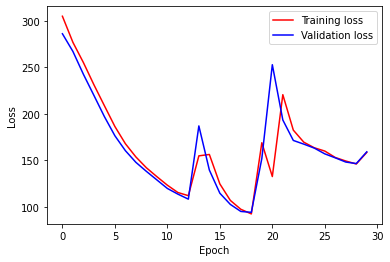

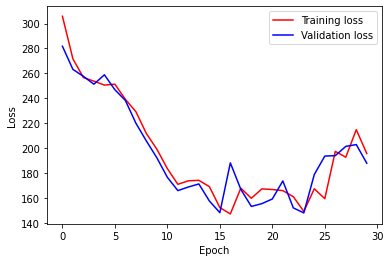

In [49]:
hornn_test_results = {}
for seq_len in seq_lens:
    train_gen = data_generator(train_data, vocab_size, seq_len, batch_size)
    test_gen = data_generator(test_data, vocab_size, seq_len, batch_size)
    val_gen =  data_generator(valid_data, vocab_size, seq_len, batch_size)

    train_steps = len(train_data)//((seq_len+1)*batch_size)
    test_steps = len(test_data)//((seq_len+1)*batch_size)
    val_steps = len(valid_data)//((seq_len+1)*batch_size)

    hornn_test_results[seq_len] = {}
    for order in orders:
        hornn_test_results[seq_len][order] = {}
        test_loss_results, test_acc_results = [], []
        for n in range(num_exp):
            print(f'HORNN {order} Experiment: {n}; seq_len: {seq_len}')
            hornn_model = HORNN(hidden_size, input_size=vocab_size, out_size=vocab_size, order=order, seq_len=seq_len)
            hidden_state = np.zeros((hidden_size, 1))  # Initial hidden_state
            hornn_train_loss, hornn_valid_loss = hornn_model.train(train_set=train_gen, valid_set=val_gen, 
                                                    hidden_state=hidden_state, num_epochs=num_epochs, 
                                                    lr=learning_rate, clip_norm=gradient_clip_norm, 
                                                    train_steps=train_steps, val_steps=val_steps)
            hornn_test_loss, hornn_test_acc = hornn_model.test(test_set=test_gen, hidden_state=hidden_state, test_steps=test_steps)
            test_loss_results.append(hornn_test_loss)
            test_acc_results.append(hornn_test_acc)
            # Plot training and validation loss
            epoch = np.arange(len(hornn_train_loss))
            plt.figure()
            plt.plot(epoch, hornn_train_loss, 'r', label='Training loss',)
            plt.plot(epoch, hornn_valid_loss, 'b', label='Validation loss')
            plt.legend()
            plt.xlabel('Epoch'), plt.ylabel('Loss')
            plt.savefig(f'char_{seq_len}__hornn{order}_exp_{n}.png')
        
        print(f'Seq_len: {seq_len}; HORNN-{order} average char test loss: {np.average(test_loss_results)}')
        print(f'Seq_len: {seq_len}; HORNN-{order} average char test acc: {np.average(test_acc_results)}')
        hornn_test_results[seq_len][order]['loss'] = np.average(test_loss_results)
        hornn_test_results[seq_len][order]['acc'] = np.average(test_acc_results)
        hornn_test_results[seq_len][order]['all_loss'] = test_loss_results.copy()
        hornn_test_results[seq_len][order]['all_acc'] = test_acc_results.copy()